In [1]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py

import torch.optim as optim
import time
import json

In [79]:
class RecursivePredictions():
    def __init__(self,net,dataset):
        """
        net : pytorch model create with the BaseModel class
        dataset : torch dataset
        """

        self.net = net
        self.dataset = dataset

        self.net = self.net.to('cpu')

        #initial_test_sample,number_of_timestep_to_predict,timestep_to_plot)
    
    def predict_all():
        """
        initial_timestep : (int) first timestep to start the predictions
        number_of_timestep_to_predict : (int) number of timestep to do the predictions
        timestep_to_plot : (list) the timesteps to plot
        """


    def predict_wavefield(self, initial_timestep,timestep_to_plot):
        """
        initial_timestep : (int) first timestep to start the predictions
        timestep_to_plot : (list) the timesteps to plot
        """

        # Wavefield to start the predictions
        initial_test_sample = self.dataset.__getitem__(initial_timestep)
        test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
        test_x = test_x.to('cpu')

        preds = np.zeros((len(timestep_to_plot),300,300))
        trues = np.zeros((len(timestep_to_plot),300,300))
        
        im = 0
        for ts in range(timestep_to_plot[-1]+1):
            # Prediciton
            test_gen = self.net(test_x)

            # Store selected wavefield
            if ts in timestep_to_plot:

                # Ground truth wavefield
                test_gt = self.dataset.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None] 

                print(f"Saving wavefield {ts}")
                preds[im,:,:] = test_gen[0,0].detach().numpy()
                trues[im,:,:] = test_gt[0,0].detach().numpy()
                im += 1

            #test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:]
            test_x = torch.cat((test_x[:,1:4,:,:],test_gen,test_x[:,-1:,:,:]),dim=1) # Next input : last three wavefields, new wavefield predicted, velocity field

        # Errors
        errors = preds - trues

        return preds, trues, errors

    def predict_norm(self, initial_timestep, number_of_timestep_to_predict):
        """
        initial_timestep : (int) first timestep to start the predictions
        number_of_timestep_to_predict : (int) the total number of timesteps on which the norm will be computed
        """
        
        start_time = time.time()

        # Wavefield to start the predictions
        initial_test_sample = self.dataset.__getitem__(initial_timestep)
        test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
        test_x = test_x.to('cpu')

        norms = []

        for ts in range(number_of_timestep_to_predict):

            # Prediciton
            test_gen = self.net(test_x) 
            pred = test_gen[0,0].detach().numpy()

            # Ground truth wavefield
            test_gt = self.dataset.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None] 
            true = test_gt[0,0].detach().numpy()

            # Update wavefield
            test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:] # Concat gen wavefield as the new input wavefield

            # Save norm
            norms.append(np.linalg.norm(true-pred))

        end_time = time.time()
        total_time = end_time - start_time

        print(f'\nTotal time for the predictions [s] for {number_of_timestep_to_predict} timesteps :',np.round(total_time,2))

        return norms
    def predict_receivers(self,initial_timestep,number_of_timestep_to_predict : list,x_locations :list ,y_locations,dh):
        """
        initial_timestep : (int) first timestep to start the predictions
        x_locations and y_locations : (list) x and y locations of the receivers
        dh : (int) element size in the mesh to match salvus output
        """

        start_time = time.time()

        # Wavefield to start the predictions
        initial_test_sample = self.dataset.__getitem__(initial_timestep)
        test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
        test_x = test_x.to('cpu')

        receivers_pred = []
        receivers_true = []

        for ts in range(number_of_timestep_to_predict):

            # Prediciton
            test_gen = self.net(test_x) 
            pred = test_gen[0,0].detach().numpy()

            # Ground truth wavefield
            test_gt = self.dataset.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None] 
            true = test_gt[0,0].detach().numpy()

            # Update wavefield
            test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:] # Concat gen wavefield as the new input wavefield

            # Save receivers values
            receivers_pred.append(pred[(x_locations/dh).astype(int),(y_locations/dh).astype(int)])
            receivers_true.append(true[(x_locations/dh).astype(int),(y_locations/dh).astype(int)])

        end_time = time.time()
        total_time = end_time - start_time

        print(f'\nTotal time for the predictions [s] for {number_of_timestep_to_predict} timesteps :',np.round(total_time,2))

        return receivers_pred, receivers_true


In [80]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [81]:
def plot_wavefields(preds, trues, errors,initial_timestep,timestep_to_plot):
    fig , axs = plt.subplots(len(timestep_to_plot),3,figsize=(17,len(timestep_to_plot)*5),squeeze=False)

    for row, ts in enumerate(timestep_to_plot):

        # Predictions
        im = axs[row,0].imshow(preds[row,:,:],norm=MidpointNormalize(midpoint=0))
        clim = im.get_clim()

        divider = make_axes_locatable(axs[row,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        axs[row,0].set_ylabel(f'Wavefield {ts}',fontsize=16)

        # True
        im = axs[row,1].imshow(trues[row,:,:],norm=MidpointNormalize(midpoint=0),clim=clim)

        divider = make_axes_locatable(axs[row,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        # Error
        im = axs[row,2].imshow(errors[row,:,:],norm=MidpointNormalize(midpoint=0))

        divider = make_axes_locatable(axs[row,2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        axs[row,0].tick_params(left=False,bottom=False)
        axs[row,0].set(yticklabels=[],xticklabels=[])
        axs[row,0].set_frame_on(False)
        axs[row,1].axis('off')
        axs[row,2].axis('off')

        if row == 0:
            axs[row,0].set_title(f'Prediction',fontsize=16)
            axs[row,1].set_title(f'True',fontsize=16)
            axs[row,2].set_title(f'Error',fontsize=16)

    fig.suptitle(f'Initital wavefield n°{initial_timestep} = 0.00 [s]', fontsize=30)
    plt.tight_layout()

In [82]:
def save_outputs(outputs,export_path):
    with open(export_path, "w") as f:
        json.dump(outputs, f)

In [83]:
class UNetModel(BaseModel):
    def __init__(self, net, opt=None, sched=None, logger=None, print_progress=True, device='cpu'):
        super().__init__(net, opt, sched, logger, print_progress, device)

    def forward_loss(self, data):
        return

In [84]:
event ='Event0000'

# Homogeneous
#training_data = dataset('Training_Data/Mosely_Homogeneous/','Training_Data/Moseley_Homogeneous_Event0000_Continuous.csv',event)

# Heterogeneous
velocity_field = 'Training_Data/Velocity_Field_1.npy'
training_data = dataset('Training_Data/Moseley_EARTH/','Training_Data/Moseley_Earth_Event0000_Continuous.csv',event,velocity_field)

In [85]:
model_type = 'Interpolation'
model_name = 'L2_E500'

net = UNet(in_channels=5,out_channels=1)

model = UNetModel(net, device='cuda:0')
model.load(import_path=f'{model_type}/unet/results/{model_name}.pt',map_location='cuda:0')

In [86]:
    def predict_wavefield(self, initial_timestep,timestep_to_plot):
        """
        initial_timestep : (int) first timestep to start the predictions
        timestep_to_plot : (list) the timesteps to plot
        """

        # Wavefield to start the predictions
        initial_test_sample = self.dataset.__getitem__(initial_timestep)
        test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
        test_x = test_x.to('cpu')

        preds = np.zeros((len(timestep_to_plot),300,300))
        trues = np.zeros((len(timestep_to_plot),300,300))
        
        im = 0
        for ts in range(timestep_to_plot[-1]+1):
            # Prediciton
            test_gen = self.net(test_x)

            # Store selected wavefield
            if ts in timestep_to_plot:

                # Ground truth wavefield
                test_gt = self.dataset.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None] 

                print(f"Saving wavefield {ts}")
                preds[im,:,:] = test_gen[0,0].detach().numpy()
                trues[im,:,:] = test_gt[0,0].detach().numpy()
                im += 1

            test_x = torch.cat((test_x[:,:1,:,:],torch.cat((test_x,test_gen),dim=1)[:,2:,:,:]),dim=1) # Predict Heterogeneous, keep the velocity field

        # Errors
        errors = preds - trues

        return preds, trues, errors

In [87]:
preds, trues, errors = RecursivePredictions(net=model.net, dataset=training_data).predict_wavefield(150,[0])

Saving wavefield 0


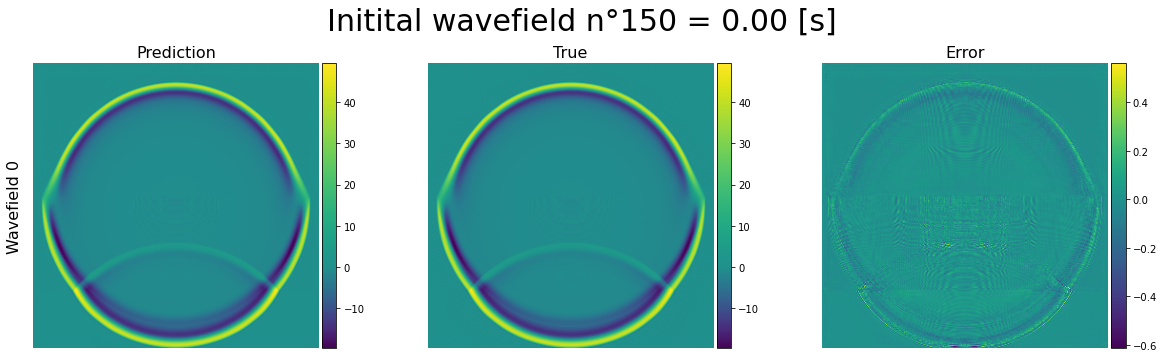

In [88]:
plot_wavefields(preds, trues, errors, 150, [0])

In [89]:
preds, trues, errors = RecursivePredictions(net=model.net, dataset=training_data).predict_wavefield(20,[0,25,50,100,150])

Saving wavefield 0
Saving wavefield 25
Saving wavefield 50
Saving wavefield 100
Saving wavefield 150


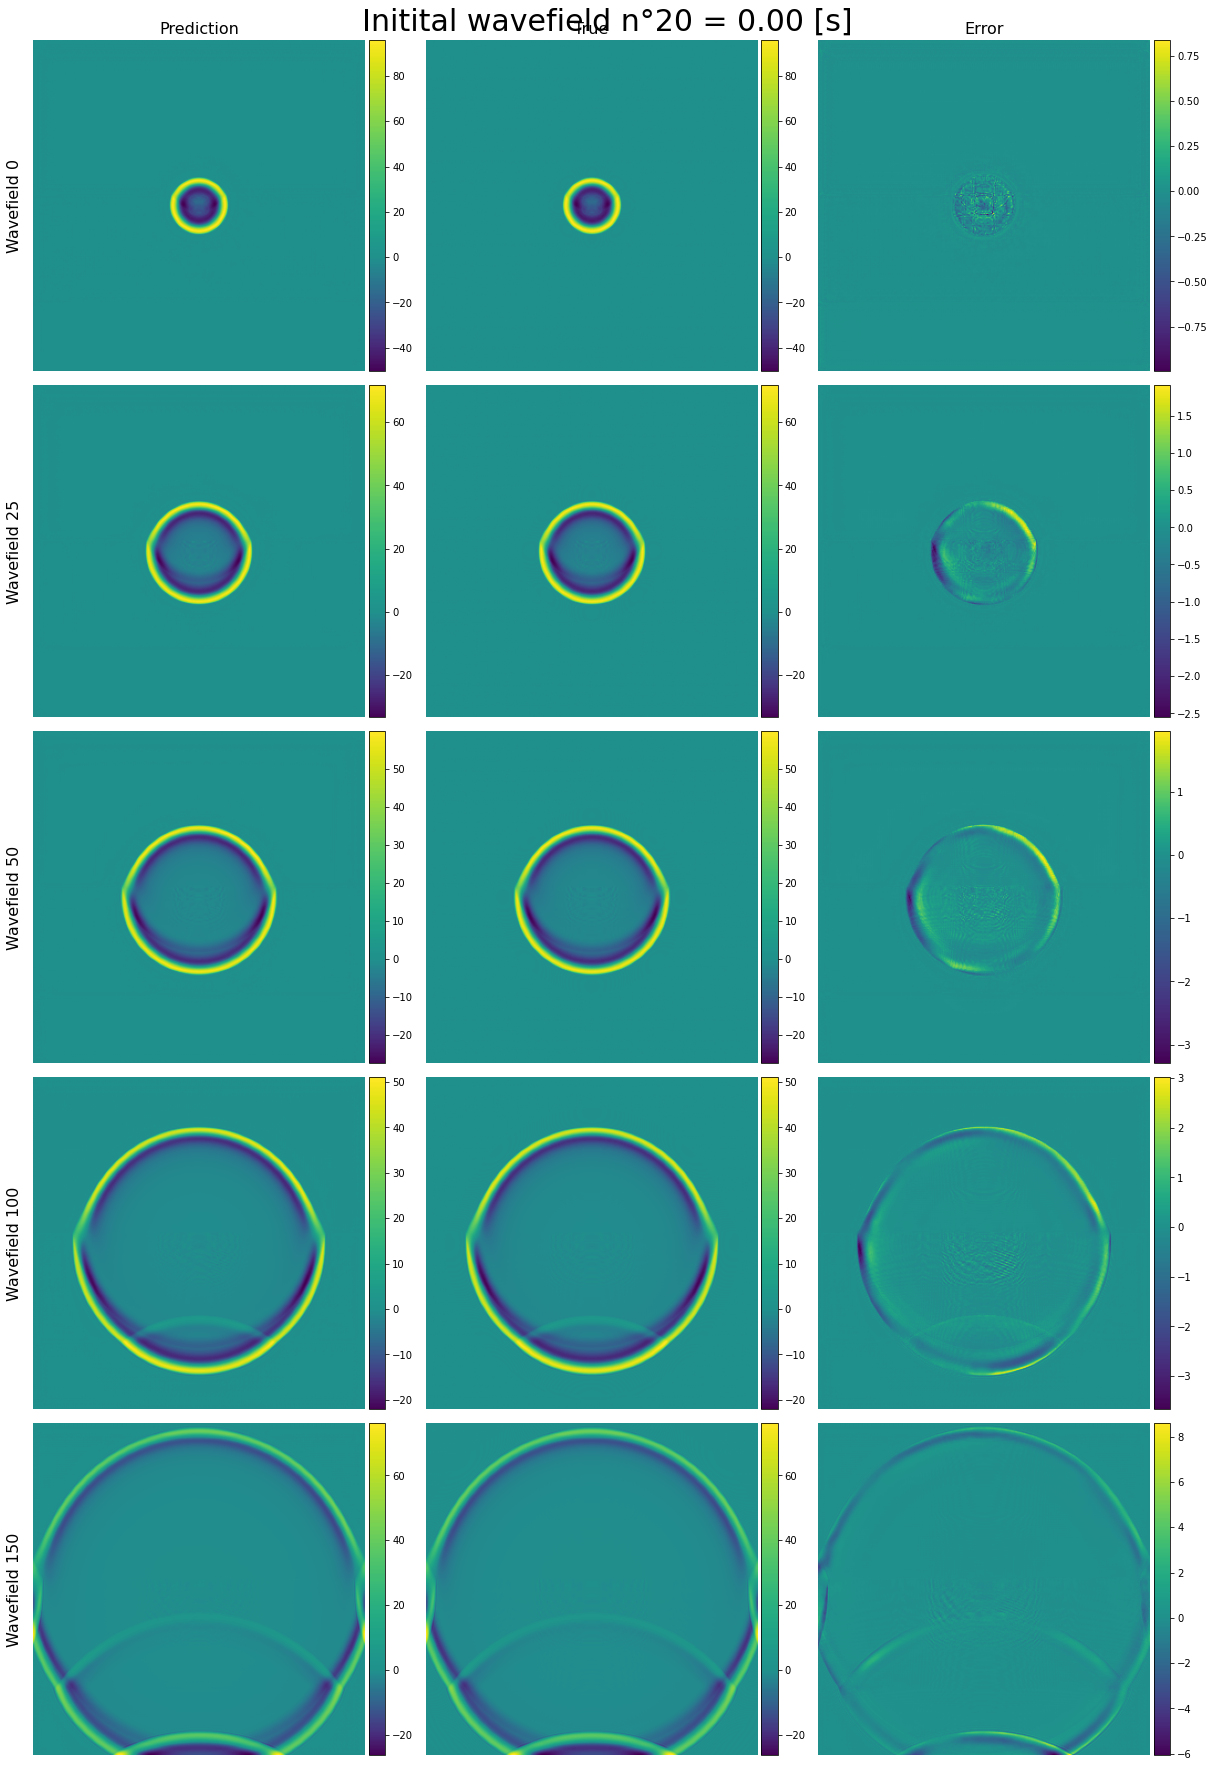

In [90]:
plot_wavefields(preds, trues, errors, 20, [0,25,50,100,150])

In [44]:
norms = RecursivePredictions(model.net,training_data).predict_norm(20,181)


Total time for the predictions [s] for 170 timesteps : 252.29


In [ ]:
save_outputs(norms,export_path)

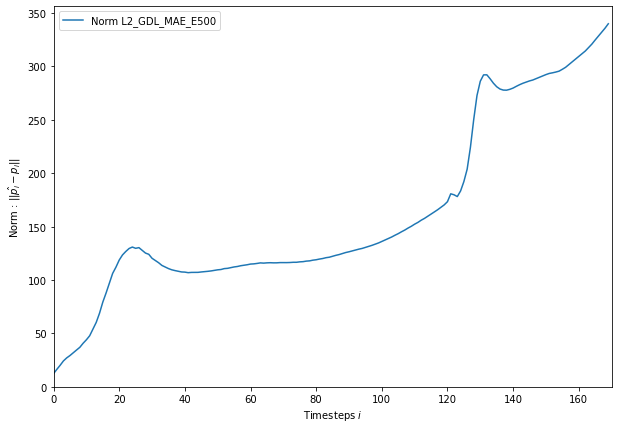

In [76]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(norms,label=f'Norm {model_name}')

plt.xlabel('Timesteps $i$')
plt.ylabel('Norm : $|| \hat{p_i} - p_i||$')
plt.xlim(0,170)
plt.ylim(0)
plt.legend()

In [28]:
x_locations = np.array([0,0])
y_locations = np.array([500,1000])

In [29]:
receivers_pred, receivers_true = RecursivePredictions(model.net,training_data).predict_receivers(20,181,x_locations=x_locations,y_locations=y_locations,dh=5)

KeyError: 191

In [7]:
path = "../NoCrack/Simple_Homogeneous_Moseley/Event0000/receivers.h5"
hf = h5py.File(path, 'r')

In [8]:
hf.keys()

<KeysViewHDF5 ['coordinates_ACOUSTIC_point', 'names_ACOUSTIC_point', 'point', 'receiver_ids_ACOUSTIC_point']>

In [9]:
receivers_ids = hf['receiver_ids_ACOUSTIC_point'][:]
receivers_ids

array([5, 6, 7, 0, 2, 1, 4, 3], dtype=int64)

In [10]:
xs = hf['coordinates_ACOUSTIC_point'][:][:,0] == 0

ys = hf['coordinates_ACOUSTIC_point'][:][:,1] == 1000

id_receiver = hf['receiver_ids_ACOUSTIC_point'][xs & ys]

In [11]:
receiver_data = hf['point']['phi'][:][id_receiver[0],0][20*10:20*10+170*10 + 1]

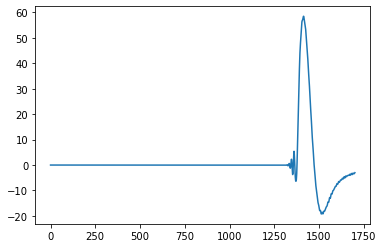

In [12]:
plt.plot(receiver_data)

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(np.array(receivers_pred)[:,0],'--',label=f'Pred : x={x_locations[0]}, y={y_locations[0]}',color='orange')
ax.plot(np.array(receivers_pred)[:,1],'--',label=f'Pred : x={x_locations[1]}, y={y_locations[1]}',color='cornflowerblue')
ax.plot(np.array(receivers_true)[:,0],label=f'True : x={x_locations[0]}, y={y_locations[0]}',color='orange')
ax.plot(np.array(receivers_true)[:,1],label=f'True : x={x_locations[1]}, y={y_locations[1]}',color='cornflowerblue')

ax.plot(receiver_data)
plt.legend()
plt.xlim(0,170)
plt.xlabel('Pressure')
plt.xlabel('Timesteps')


In [189]:
# See line plot input - output 
wave_in = training_data.__getitem__(initial_timestep)['wave_input'][0]
wave_out = training_data.__getitem__(initial_timestep)['wave_output'][0]
pred_out = outputs[0][150,:]

NameError: name 'outputs' is not defined

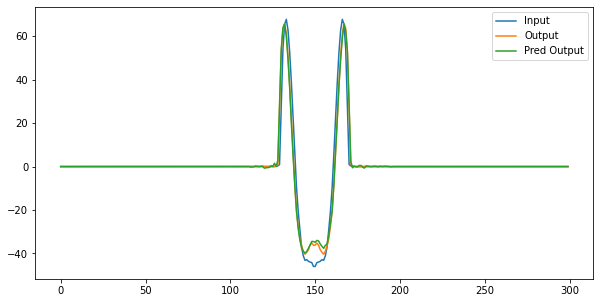

In [102]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(wave_in,label='Input')
ax.plot(wave_out,label='Output')
ax.plot(pred_out, label='Pred Output')
plt.legend()

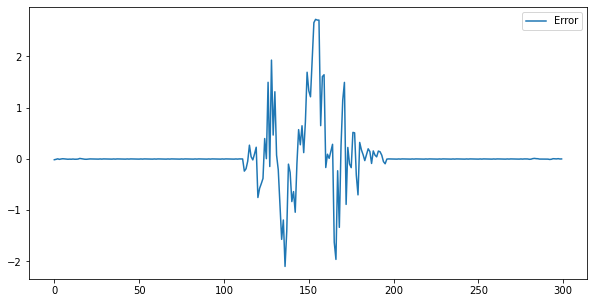

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(wave_out-wave_in,label='Error')
ax.plot(pred_out-wave_out,label='Error')
plt.legend()